In [1]:
import sys
!{sys.executable} -m pip install geopandas descartes

In [18]:
import os
import pandas as pd
from math import radians
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import math
from scipy.spatial import distance
%matplotlib inline

In [3]:
df = pd.read_csv(os.path.expanduser('~/data/DataSample.csv'))

In [4]:
# check column names
for col in df.columns:
    print(col)

_ID
 TimeSt
Country
Province
City
Latitude
Longitude


In [12]:
df

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730
...,...,...,...,...,...,...,...
22020,5614801,2017-06-21 12:23:07.880,CA,ON,Saint Catharines,43.16440,-79.24560
22021,5614888,2017-06-21 08:23:01.793,CA,AB,Calgary,51.02093,-114.10621
22022,5614909,2017-06-21 00:23:07.903,CA,ON,Whitby,43.88730,-78.94220
22023,5614912,2017-06-21 11:23:07.953,CA,ON,Oakville,43.49340,-79.71260


# 1. Cleanup

In [5]:
#how many identical records based on ther geoinfo and timest
sus_recs = []
for record in df.duplicated(subset = [' TimeSt', 'Longitude', 'Latitude'], keep = False):
    if record:
        sus_recs.append(record)
print(len(sus_recs))

4052


In [7]:
#drop all suspicious records 
df1 = df.drop_duplicates(subset = [' TimeSt', 'Longitude', 'Latitude'], keep = False)

In [11]:
df1

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730
...,...,...,...,...,...,...,...
22018,5614689,2017-06-21 13:23:01.370,CA,ON,London,42.96110,-81.24310
22020,5614801,2017-06-21 12:23:07.880,CA,ON,Saint Catharines,43.16440,-79.24560
22022,5614909,2017-06-21 00:23:07.903,CA,ON,Whitby,43.88730,-78.94220
22023,5614912,2017-06-21 11:23:07.953,CA,ON,Oakville,43.49340,-79.71260


In [46]:
#reset indexes
new_df = df1.reset_index(drop=True)

In [47]:
#checked Canada's extreme points, removed all sus coordinates
new_df = new_df[new_df.Longitude < -50]
new_df = new_df[new_df.Latitude >41]
new_df = new_df[new_df.Longitude > -142]
new_df = new_df[new_df.Latitude <84]
new_df = new_df.reset_index(drop=True)

In [48]:
new_df

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730
...,...,...,...,...,...,...,...
17949,5614689,2017-06-21 13:23:01.370,CA,ON,London,42.96110,-81.24310
17950,5614801,2017-06-21 12:23:07.880,CA,ON,Saint Catharines,43.16440,-79.24560
17951,5614909,2017-06-21 00:23:07.903,CA,ON,Whitby,43.88730,-78.94220
17952,5614912,2017-06-21 11:23:07.953,CA,ON,Oakville,43.49340,-79.71260


# 2. Label

In [13]:
poi = pd.read_csv(os.path.expanduser('~/data/POIList.csv'))
poi

,POIID,Latitude,Longitude
0,POI1,53.546167,-113.485734
1,POI2,53.546167,-113.485734
2,POI3,45.521629,-73.566024
3,POI4,45.224830,-63.232729


POI1 = POI2, so I'll drop one of them

In [16]:
poi = poi.drop_duplicates(subset = ['Longitude', ' Latitude'], keep = 'last')
poi = poi.reset_index(drop=True)
poi

,POIID,Latitude,Longitude
0,POI2,53.546167,-113.485734
1,POI3,45.521629,-73.566024
2,POI4,45.224830,-63.232729


In [17]:
# function to calculate the distance between points based on coordinates
def haversine_distance(coord1, coord2):
    lat1 = coord1[0]
    lon1 = coord1[1]
    lat2 = coord2[0]
    lon2 = coord2[1]
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    return np.round(res, 2)

In [19]:
coords = list(zip(new_df['Latitude'], new_df['Longitude']))
poi_coords = list(zip(poi[' Latitude'], poi['Longitude']))

In [20]:
# distances between requests and each POI
dist = distance.cdist(coords, poi_coords, haversine_distance)

array([[2643.75,  593.41, 1382.79],
       [2630.72,  677.31, 1459.84],
       [2655.75,  569.65, 1359.33],
       ...,
       [2718.66,  462.  , 1251.55],
       [2694.24,  536.87, 1321.86],
       [2694.21,  544.65, 1328.58]])

In [33]:
# creating array with min distances to each POI
distance =[[min(pp), poi['POIID'][np.argmin(pp)]] for pp in dist]

In [49]:
new_df = new_df.join(pd.DataFrame(data = distance, columns = ['distance', 'POI']))
new_df

,_ID,TimeSt,Country,Province,City,Latitude,Longitude,distance,POI
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123,593.41,POI3
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090,677.31,POI3
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010,569.65,POI3
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730,634.73,POI3
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730,634.73,POI3
...,...,...,...,...,...,...,...,...,...
17949,5614689,2017-06-21 13:23:01.370,CA,ON,London,42.96110,-81.24310,674.21,POI3
17950,5614801,2017-06-21 12:23:07.880,CA,ON,Saint Catharines,43.16440,-79.24560,522.02,POI3
17951,5614909,2017-06-21 00:23:07.903,CA,ON,Whitby,43.88730,-78.94220,462.00,POI3
17952,5614912,2017-06-21 11:23:07.953,CA,ON,Oakville,43.49340,-79.71260,536.87,POI3


In [124]:
poi

,POIID,Latitude,Longitude,geometry
0,POI2,53.546167,-113.485734,POINT (-113.48573 53.54617)
1,POI3,45.521629,-73.566024,POINT (-73.56602 45.52163)
2,POI4,45.224830,-63.232729,POINT (-63.23273 45.22483)


In [163]:
iii = poi[' Latitude'][poi.index[poi['POIID'].values=='POI2']]
iii[0]

53.546167

In [158]:
dddd = poi.index[poi['POIID'].values=='POI2']
dddd

Int64Index([0], dtype='int64')

# 3. Analysis

In [164]:
new_max = [new_df.loc[new_df.loc[new_df.POI == my_poi].distance.idxmax()] for my_poi in poi['POIID']]
new_max[0]['Latitude']

62.8273

In [139]:
new_mean = new_df.groupby(new_df.POI).distance.mean()
new_mean

POI
POI2    294.393756
POI3    451.651066
POI4    242.913309
Name: distance, dtype: float64

In [140]:
df_std = new_df.groupby(new_df.POI).distance.std()
df_std

POI
POI2    284.415721
POI3    223.631883
POI4    229.168911
Name: distance, dtype: float64

In [79]:
# downloaded Cartographic Boundary File from 
#https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/bound-limit-2011-eng.cfm
canada = gpd.read_file('gpr_000b11a_e.shp')

In [82]:
geom_poi = [Point(xy) for xy in zip(poi['Longitude'], poi[' Latitude'])]
geom_poi

In [83]:
crs = 'EPSG:4326'
geo_poi = gpd.GeoDataFrame(poi, crs=crs,geometry=geom_poi)
geo_poi

,POIID,Latitude,Longitude,geometry
0,POI2,53.546167,-113.485734,POINT (-113.48573 53.54617)
1,POI3,45.521629,-73.566024,POINT (-73.56602 45.52163)
2,POI4,45.224830,-63.232729,POINT (-63.23273 45.22483)


In [84]:
geometry = [Point(xy) for xy in zip(new_df['Longitude'], new_df['Latitude'])]
geo_df = gpd.GeoDataFrame(new_df, crs=crs,geometry=geometry)
geo_df.head()

,_ID,TimeSt,Country,Province,City,Latitude,Longitude,distance,POI,geometry
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123,593.41,POI3,POINT (-80.49123 43.49347)
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090,677.31,POI3,POINT (-81.27090 42.93990)
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010,569.65,POI3,POINT (-80.22010 43.57760)
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730,634.73,POI3,POINT (-80.97730 43.37160)
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730,634.73,POI3,POINT (-80.97730 43.37160)


In [103]:
# calculate radius of circles using pythagorean theorem 
def radius(lat1, lon1, lat2, lon2):
    
    a = abs(lat2-lat1)
    b = abs(lon2-lon1)
    c = math.sqrt(a**2+b**2)
    return c

In [130]:
# centres of circles
lon20 = geo_poi['Longitude'][0]
lon21 = geo_poi['Longitude'][1]
lon22 = geo_poi['Longitude'][2]
lat20 = geo_poi[' Latitude'][0]
lat21 = geo_poi[' Latitude'][1]
lat22 = geo_poi[' Latitude'][2]
circle2 = (lon20, lat20)
circle3 = (lon21,lat21)
circle4 = (lon22, lat22)

In [165]:
# max_distance aka radius
rad_lon20 = new_max[0]['Longitude']
rad_lon21 = new_max[1]['Longitude']
rad_lon22 = new_max[2]['Longitude']
rad_lat20 = new_max[0]['Latitude']
rad_lat21 = new_max[1]['Latitude']
rad_lat22 = new_max[2]['Latitude']

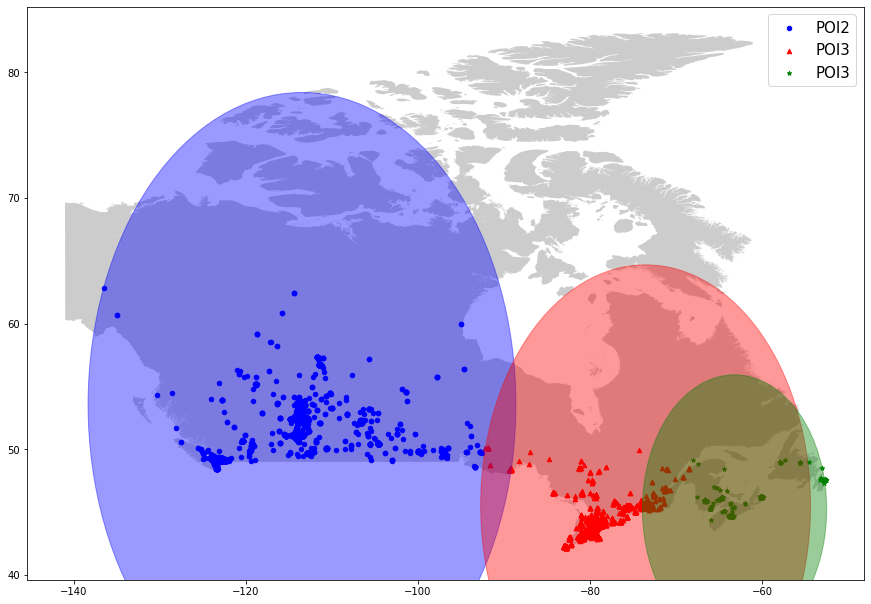

In [166]:
fig,ax = plt.subplots(figsize = (15,15))
canada.plot(ax=ax,alpha = 0.4, color='grey')
poi_circle2 = plt.Circle(circle2, radius(rad_lat20, rad_lon20, lat20, lon20),alpha = 0.4, color='blue')
poi_circle3 = plt.Circle(circle3, radius(rad_lat21, rad_lon21, lat21, lon21),alpha = 0.4, color='red')
poi_circle4 = plt.Circle(circle4, radius(rad_lat22, rad_lon22, lat22, lon22),alpha = 0.4, color='green')
geo_df[geo_df['POI'] == 'POI2'].plot(ax=ax, markersize = 20, color = 'blue', marker = 'o', label = 'POI2')
geo_df[geo_df['POI'] == 'POI3'].plot(ax=ax, markersize = 20, color = 'red', marker = '^', label = 'POI3')
geo_df[geo_df['POI'] == 'POI4'].plot(ax=ax, markersize = 20, color = 'green', marker = '*', label = 'POI3')
ax.add_patch(poi_circle2)
ax.add_patch(poi_circle3)
ax.add_patch(poi_circle4)
plt.legend(prop={'size':15})

In [172]:
#requests by POI
reqs2 = len(new_df.loc[new_df['POI'] == 'POI2'])
reqs3 = len(new_df.loc[new_df['POI'] == 'POI3'])
reqs4 = len(new_df.loc[new_df['POI'] == 'POI4'])

In [181]:
print(reqs2,reqs3,reqs4)

8744 8802 408


In [179]:
#area by POI
area_poi2 = math.pi*(radius(rad_lat20, rad_lon20, lat20, lon20))**2
area_poi3 = math.pi*(radius(rad_lat21, rad_lon21, lat21, lon21))**2
area_poi4 = math.pi*(radius(rad_lat22, rad_lon22, lat22, lon22))**2

In [182]:
print(area_poi2,area_poi3,area_poi4)

1940.3066347803444 1152.7382183296518 359.93022785829885


In [180]:
#density by POI
density_poi2 = reqs2/area_poi2
desity_poi3 = reqs3/area_poi3
density_po4 = reqs4/area_poi4
print(density_poi2, desity_poi3, density_po4)

4.506504200553785 7.635731912102586 1.1335530289515605
